# Exploratory data analysis

## Imports

In [28]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
from sklearn import cluster
from sklearn import metrics
from sklearn.decomposition import PCA
from scipy.cluster import hierarchy
from sklearn.cluster import AgglomerativeClustering
import re
import numpy as np
import matplotlib.pyplot as plt

## Load the data

Lists that have been stored in CSV aren't automatically parsed by `pandas`. Thus this small function converts a string in the form `'{'banana', 'orange', 'tangerine'}'` in a Python list containing the same elements

In [23]:
def string_to_list(column):
    return [element.strip(" ") for element in column.strip("{}").replace("'", "").split(", ")]


def combine_fyp(hashtag):
    if re.search(r"(^fy)|(^for)|(^4u)", hashtag, flags=re.IGNORECASE):
        return "fyp"
    else:
        return hashtag


def clean_hashtag_list(hashtag_list):
    return sorted(list(set([combine_fyp(hashtag) for hashtag in hashtag_list])))

Simply use `read_csv` to import the data. We ignore the first column since we do not need these repeating ids. We can then apply our `string_to_list` function to the list of hashtags

In [24]:
tiktoks = pd.read_csv("./data/tiktoks_500.csv", usecols=range(1,8), parse_dates=["date"])
tiktoks.hashtags = tiktoks.hashtags.apply(string_to_list)
tiktoks.hashtags = tiktoks.hashtags.apply(clean_hashtag_list)
tiktoks.head(5)

,video_id,hashtags,date,user_id,n_likes,n_comments,n_shared
0,-4937456930930190897,"[aussie, biden2020, bidenharris2020, straya]",2020-11-07 01:51:07,-9074424973670462894,8300000,82700,238100
1,2837885220496618646,"[biden, biden2020, election2020, fyp, fürdich,...",2020-11-06 18:11:03,7802184149743201610,7200000,154800,536900
2,-7616690630605139661,"[biden2020, fyp]",2020-10-19 18:41:40,8599333060831776201,5000000,104800,400500
3,-1485617807006866345,"[biden2020, fyp, parati, repost, trump, trump2...",2020-06-16 22:41:10,-2163225678390988754,5000000,136100,356100
4,8847244246175840872,[biden2020],2020-10-31 23:04:55,8834409548135308984,4600000,68700,218100


## Word2Vec

In [71]:
word2vec = Word2Vec(tiktoks.hashtags, vector_size=50, min_count=1, sg=1)

In [72]:
def vectorize(hashtags, word2vec):
    vec = []
    a = True
    for hashtag in hashtags:
        if a:
            vec = word2vec.wv[hashtag]
        else:
            vec = np.add(vec, word2vec.wv[hashtag])
    return np.asarray(vec)/len(vec)

In [73]:
X = np.array([vectorize(hashtags, word2vec) for hashtags in tiktoks.hashtags])

## KMeans clustering

In [78]:
wcss = list()
for n in range(1,10):
    kmeans = KMeans(n_clusters=n, init="k-means++", random_state=100)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

Let's find the optimal numver of clusters using the elboew method

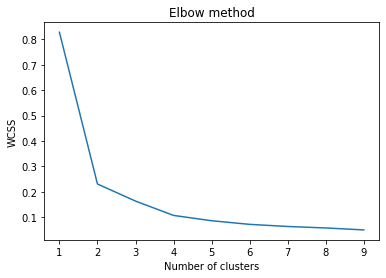

In [79]:
plt.plot(range(1,10), wcss)
plt.title("Elbow method")
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.show()

It seems like the optimal number is 2. So let's create a Kmeans with two centroids

In [80]:
n_clusters = 2
clf = KMeans(n_clusters=n_clusters, max_iter=100, init="k-means++", n_init=1)
labels = clf.fit_predict(X)

We can try to visualize these clusters on a 2d plane after transforming them using PCA

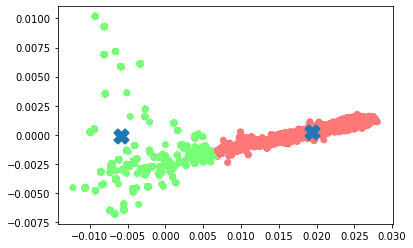

In [86]:
pca = PCA(n_components=2).fit(X)
coords = pca.transform(X)
label_colors = ["#FF7777", "#77FF77"]
colors = [label_colors[i] for i in labels]
plt.scatter(coords[:,0], coords[:,1], c=colors)
centroids = clf.cluster_centers_
centroid_coords = pca.transform(centroids)
plt.scatter(centroid_coords[:,0], centroid_coords[:,1], marker="X", s=200, linewidths=2)
plt.show()

## Hierarchichal clustering

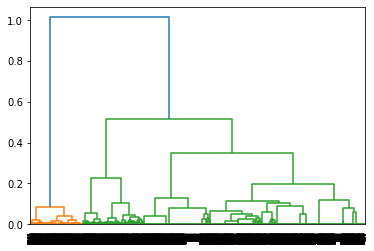

In [87]:
Z=hierarchy.linkage(X, "ward")
dn = hierarchy.dendrogram(Z)

Again this analysis shows that there are 2 clusters. Let's try to visualize them on a 2d plane with PCA

In [89]:
hc = AgglomerativeClustering(n_clusters=2, linkage="ward")
y_hc = hc.fit_predict(X)

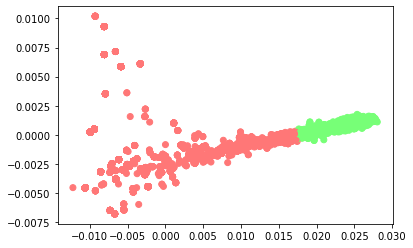

In [91]:
colors = [label_colors[i] for i in y_hc]
plt.scatter(coords[:,0], coords[:,1], c=colors)
plt.show()